# Multi Agent Network
https://langchain-ai.github.io/langgraph/tutorials/multi_agent/multi-agent-collaboration/

In [2]:
# ===============================
# Load environmental variables
# -------------------------------
from dotenv import load_dotenv


In [3]:
load_dotenv()

True

In [8]:
# ========================================
# Create Agent Framework
# ----------------------------------------
from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    ToolMessage,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langgraph.graph import END, StateGraph, START
from typing import List

class Tool:
    def __init__(self, name: str):
        self.name = name

def create_agent(llm, tools: List[Tool], system_message: str)  -> ChatPromptTemplate:
    """Create an agent."""
    prompt = ChatPromptTemplate(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    return prompt | llm.bind_tools(tools)

In [103]:
# ==============================
# Define Tools
# ------------------------------

from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

tavily_tool = TavilySearchResults(max_results=5)

# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL(verbose=True,
                  allow_dangerous_code=True,)


@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

In [104]:
# ============================
# Create Graph:
#   Define State-Engine
# ----------------------------

import operator
from typing import Annotated, Sequence
from typing_extensions import TypedDict

from langchain_openai import ChatOpenAI


# This defines the object that is passed between each node
# in the graph. We will create different nodes for each agent and tool
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str

In [105]:
# =============================
# Define Agent Nodes
# -----------------------------

import functools

from langchain_core.messages import AIMessage


# Helper function to create a node for a given agent
def agent_node(state, agent, name):
    result = agent.invoke(state)
    # We convert the agent output into a format that is suitable to append to the global state
    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
    return {
        "messages": [result],
        # Since we have a strict workflow, we can
        # track the sender so we know who to pass to next.
        "sender": name,
    }


llm = ChatOpenAI(model="gpt-4o")

# Research agent and node
research_agent = create_agent(
    llm,
    [tavily_tool],
    system_message="You should provide accurate data for use, "
        "and source code shouldn't be the final answer",
)
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

# chart_generator
chart_agent = create_agent(
    llm,
    [python_repl],
    system_message="Run the python code to display the chart.",
)
chart_node = functools.partial(agent_node, agent=chart_agent, name="chart_generator")

In [106]:
# ==================================
# Define Tool Nodes
# ----------------------------------

from langgraph.prebuilt import ToolNode

tools = [tavily_tool, python_repl]
tool_node = ToolNode(tools)

In [107]:
# =====================
# Define Edge Logic
# ---------------------

# Either agent can decide to end
from typing import Literal


def router(state):
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        # The previous agent is invoking a tool
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return "continue"

In [108]:
# ========================
# Define the Graph
# ------------------------

workflow = StateGraph(AgentState)

workflow.add_node("Researcher", research_node)
workflow.add_node("chart_generator", chart_node)
workflow.add_node("call_tool", tool_node)

workflow.add_conditional_edges(
    "Researcher",
    router,
    {"continue": "chart_generator", "call_tool": "call_tool", END: END},
)
workflow.add_conditional_edges(
    "chart_generator",
    router,
    {"continue": "Researcher", "call_tool": "call_tool", END: END},
)

workflow.add_conditional_edges(
    "call_tool",
    # Each agent node updates the 'sender' field
    # the tool calling node does not, meaning
    # this edge will route back to the original agent
    # who invoked the tool
    lambda x: x["sender"],
    {
        "Researcher": "Researcher",
        "chart_generator": "chart_generator",
    },
)
workflow.add_edge(START, "Researcher")
graph = workflow.compile()

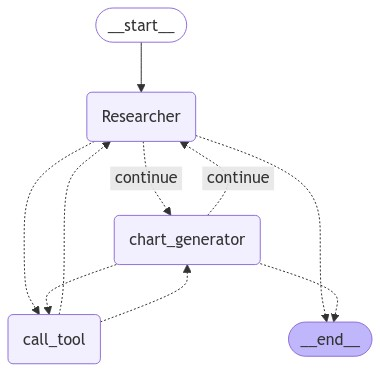

In [109]:
# ==============================
# Display the Graph
# ------------------------------
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

{'Researcher': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_b5qzLAb8HciyitQt7Ee63NLf', 'function': {'arguments': '{"query":"UK GDP data 2013 to 2023"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 256, 'total_tokens': 283, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_45c6de4934', 'finish_reason': 'tool_calls', 'logprobs': None}, name='Researcher', id='run-6636ac87-a049-4d66-ba6c-08dcfd172e02-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'UK GDP data 2013 to 2023'}, 'id': 'call_b5qzLAb8HciyitQt7Ee63NLf', 'type': 'tool_call'}], usage_metadata={'input_tokens': 256, 'output_tokens': 27, 'total_tokens': 283, 'input_token_details': {'cache_read': 0}, 'output_

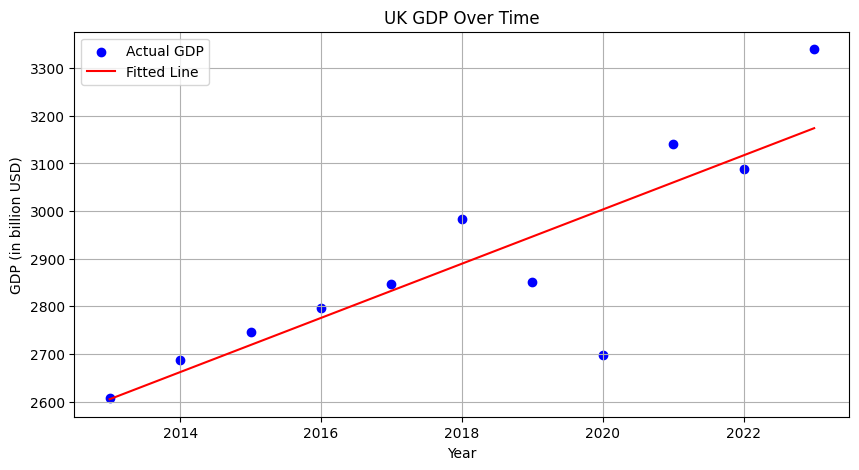

{'call_tool': {'messages': [ToolMessage(content="Successfully executed:\n```python\nimport numpy as np\nimport matplotlib.pyplot as plt\nfrom sklearn.linear_model import LinearRegression\n\n# Data\nyears = np.array([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]).reshape(-1, 1)\ngdp = np.array([2607.05, 2687.61, 2746.33, 2795.65, 2846.83, 2982.62, 2850.15, 2697.81, 3141.51, 3088.84, 3340.03])\n\n# Fit line\nmodel = LinearRegression()\nmodel.fit(years, gdp)\n\n# Prediction\npredicted_gdp = model.predict(years)\n\n# Plot\nplt.figure(figsize=(10, 5))\nplt.scatter(years, gdp, color='blue', label='Actual GDP')\nplt.plot(years, predicted_gdp, color='red', label='Fitted Line')\nplt.xlabel('Year')\nplt.ylabel('GDP (in billion USD)')\nplt.title('UK GDP Over Time')\nplt.legend()\nplt.grid(True)\nplt.show()\n```\nStdout: \n\nIf you have completed all tasks, respond with FINAL ANSWER.", name='python_repl', tool_call_id='call_IqtX8M0aJLvCcpk5BLYjkxsr')]}}
----
{'chart_generator':

In [111]:
# ============================
# Execute the Graph
# ----------------------------

events = graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Fetch the USA's GDP over the past 10 years,"
                " then write a python program to fit a line to the GDP data."
                " To develop a line graph you will need to import matlibplot and scikit-learn."
                " Once you code it up execute the code to generate the plot and print it out."
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 15},
)
for s in events:
    print(s)
    print("----")

In [99]:
help(HumanMessage)

Help on class HumanMessage in module langchain_core.messages.human:

class HumanMessage(langchain_core.messages.base.BaseMessage)
 |  HumanMessage(content: Union[str, list[Union[str, dict]]], *, additional_kwargs: dict = None, response_metadata: dict = None, type: Literal['human'] = 'human', name: Optional[str] = None, id: Optional[str] = None, example: bool = False, **kwargs: Any) -> None
 |
 |  Message from a human.
 |
 |  HumanMessages are messages that are passed in from a human to the model.
 |
 |  Example:
 |
 |      .. code-block:: python
 |
 |          from langchain_core.messages import HumanMessage, SystemMessage
 |
 |          messages = [
 |              SystemMessage(
 |                  content="You are a helpful assistant! Your name is Bob."
 |              ),
 |              HumanMessage(
 |                  content="What is your name?"
 |              )
 |          ]
 |
 |          # Instantiate a chat model and invoke it with the messages
 |          model = ...
 |   